In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import packages
import glob
import os.path as osp
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import models, transforms

In [3]:
# setting random number seed.
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# preprocess class for each image
class ImageTransform():
    def __init__(self, size, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                # data augmentation
                transforms.RandomResizedCrop(size, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                # convert to tensor for PyTorch
                transforms.ToTensor(),
                # color normalization
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase='train'):

        return self.data_transform[phase](img)

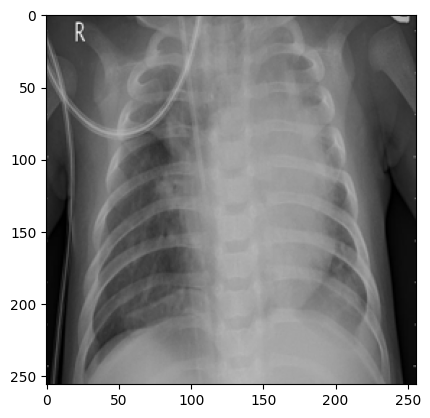

torch.Size([3, 256, 256])


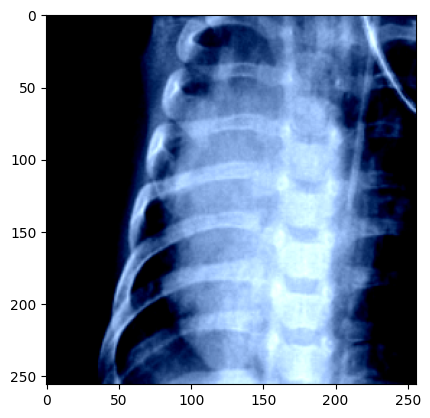

In [4]:
image_file_path = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person100_bacteria_479.jpeg'

img_originalsize = Image.open(image_file_path) # [channel, ]
img = img_originalsize.resize((256, 256))
img = img.convert("L").convert("RGB")
plt.imshow(img)
plt.show()

# after preprocess
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")
print (img_transformed.shape)

# (color, height, width) -> (height, width, color), normalize colors in the range (0 - 1)
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()


In [5]:
import os.path as osp
import glob

# Making file path list
def make_datapath_list(phase="train"):
    # CORRECTED: Use the full path to your dataset
    rootpath = "/content/chest_xray"


    # Look for both .jpeg and .jpg files (and other potential extensions)
    target_path = osp.join(rootpath, phase, "**", "*.jp*g")
    path_list = glob.glob(target_path, recursive=True)

    # Print a helpful message if no files found
    if len(path_list) == 0:
        print(f"No files found at {target_path}. Please check the path.")

    return path_list

train_list = make_datapath_list(phase="train")
print(train_list)

val_list = make_datapath_list(phase="val")
print(len(val_list))


['/content/chest_xray/train/PNEUMONIA/person961_bacteria_2886.jpeg', '/content/chest_xray/train/PNEUMONIA/person102_virus_189.jpeg', '/content/chest_xray/train/PNEUMONIA/person489_bacteria_2063.jpeg', '/content/chest_xray/train/PNEUMONIA/person1141_bacteria_3085.jpeg', '/content/chest_xray/train/PNEUMONIA/person502_virus_1012.jpeg', '/content/chest_xray/train/PNEUMONIA/person506_bacteria_2136.jpeg', '/content/chest_xray/train/PNEUMONIA/person12_bacteria_47.jpeg', '/content/chest_xray/train/PNEUMONIA/person819_bacteria_2730.jpeg', '/content/chest_xray/train/PNEUMONIA/person1630_bacteria_4304.jpeg', '/content/chest_xray/train/PNEUMONIA/person55_bacteria_266.jpeg', '/content/chest_xray/train/PNEUMONIA/person293_virus_605.jpeg', '/content/chest_xray/train/PNEUMONIA/person842_virus_1483.jpeg', '/content/chest_xray/train/PNEUMONIA/person707_bacteria_2606.jpeg', '/content/chest_xray/train/PNEUMONIA/person1004_bacteria_2935.jpeg', '/content/chest_xray/train/PNEUMONIA/person348_virus_723.jpeg',

In [6]:
def collate_fn(batch):
    # Skip None items (missing or corrupted images)
    batch = [item for item in batch if item is not None]
    return torch.utils.data.dataloader.default_collate(batch)


In [7]:
import os.path as osp
from PIL import Image, UnidentifiedImageError

class lungDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]

        try:
            # Open the image and handle exceptions
            img_originalsize = Image.open(img_path)

            # Resize the image
            img = img_originalsize.resize((256, 256))
            img = img.convert("L").convert("RGB")

            # Apply transformation (if any)
            img_transformed = self.transform(img, self.phase)

            # Handle directory structure for labels
            parent_dir = osp.basename(osp.dirname(img_path))

            if parent_dir == "NORMAL":
                label = 0
            elif parent_dir == "PNEUMONIA":
                label = 1
            else:
                # Fallback in case the directory structure is different
                if "NORMAL" in img_path:
                    label = 0
                else:
                    label = 1

            return img_transformed, label

        except (FileNotFoundError, UnidentifiedImageError) as e:
            # Print a warning and skip this image if it's missing or corrupted
            print(f"Skipping missing or corrupted file: {img_path} ({e})")
            # Return a placeholder or None (you'll need to handle this in your DataLoader)
            return None

# Create datasets using the updated class
train_dataset = lungDataset(file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = lungDataset(file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# Verify the datasets were created correctly
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Try to access the first item to verify the label extraction works
if len(train_dataset) > 0:
    img, label = train_dataset[0]
    if img is not None:
        print(f"First training sample has label: {label} ({'NORMAL' if label == 0 else 'PNEUMONIA'})")
        print(f"Image tensor shape: {img.shape}")

Training dataset size: 5215
Validation dataset size: 16
First training sample has label: 1 (PNEUMONIA)
Image tensor shape: torch.Size([3, 256, 256])


In [8]:
batch_size = 64  # Increased batch size (adjust if you run out of memory)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}


In [9]:
import torch
import torch.utils.data

# Assuming you have your datasets created as `train_dataset` and `val_dataset`
train_dataset = lungDataset(file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = lungDataset(file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# Define the collate_fn to skip None items
def collate_fn(batch):
    # Skip None items (missing or corrupted images)
    batch = [item for item in batch if item is not None]
    return torch.utils.data.dataloader.default_collate(batch)

# Create DataLoader objects with the custom collate_fn
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn, shuffle=False)

# Verify the datasets were created correctly
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Example: Try to access the first item from the train_loader
data_iter = iter(train_loader)
img, label = next(data_iter)

# Access the first label in the batch
label_value = label[0].item()  # Access the first label in the batch and convert it to a scalar

print(f"First training sample has label: {label_value} ({'NORMAL' if label_value == 0 else 'PNEUMONIA'})")


Training dataset size: 5215
Validation dataset size: 16
First training sample has label: 1 (PNEUMONIA)


In [10]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

# Replace output layer for 2 class classifier, 'NORMAL' and 'PNEUMONIA'.
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
net.train()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
criterion = nn.CrossEntropyLoss()
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        # print("params_to_update_1:", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        #print("params_to_update_2:", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        #print("params_to_update_3:", name)

    else:
        param.requires_grad = False
        #print("no learning", name)

# Set learning rates
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)


In [12]:
# training function
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    accuracy_list = []
    loss_list = []

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using device：", device)
    net.to(device)
    torch.backends.cudnn.benchmark = True

    # epoch loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for i, (inputs, labels) in enumerate(dataloaders_dict[phase]):

                print (f'Iteration: ', i)
                print (labels)

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    # Forward pass
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # Calcurate loss
                    _, preds = torch.max(outputs, 1)  # Prediction

                    # Back propagtion
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # update loss summation
                    epoch_loss += loss.item() * inputs.size(0)
                    # update correct prediction summation
                    epoch_corrects += torch.sum(preds == labels.data)

            # loss and accuracy for each epoch loop
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                accuracy_list.append(epoch_acc.item())
                loss_list.append(epoch_loss)

    return accuracy_list, loss_list


In [13]:
from PIL import Image, UnidentifiedImageError
import os

def clean_corrupted_images(root_dir):
    removed = 0
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            filepath = os.path.join(subdir, file)
            try:
                with Image.open(filepath) as img:
                    img.verify()  # Verifies file integrity
            except (UnidentifiedImageError, OSError):
                print(f"Removing corrupted file: {filepath}")
                os.remove(filepath)
                removed += 1
    print(f"✅ Done cleaning. Total corrupted files removed: {removed}")

# Run it once
clean_corrupted_images('/content/chest_xray')


✅ Done cleaning. Total corrupted files removed: 0


In [14]:
import os

# Check if the file still exists
img_path = '/content/chest_xray/train/PNEUMONIA/person1502_bacteria_3923.jpeg'
if not os.path.exists(img_path):
    print(f"File {img_path} is missing. Skipping...")
else:
    img = Image.open(img_path)
    img.show()


File /content/chest_xray/train/PNEUMONIA/person1502_bacteria_3923.jpeg is missing. Skipping...


In [15]:
import os
from PIL import Image, UnidentifiedImageError

def log_missing_files(root_dir, log_file='missing_files.log'):
    with open(log_file, 'w') as log:
        for subdir, _, files in os.walk(root_dir):
            for file in files:
                file_path = os.path.join(subdir, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # Verify if image is corrupted
                except (UnidentifiedImageError, OSError):
                    log.write(f"Corrupted file: {file_path}\n")
                except FileNotFoundError:
                    log.write(f"Missing file: {file_path}\n")

log_missing_files('/content/chest_xray/train/PNEUMONIA')
log_missing_files('/content/chest_xray/train/NORMAL')


In [16]:
import os

# Check number of files in each folder
def check_files_in_folder(folder_path):
    for subdir, dirs, files in os.walk(folder_path):
        print(f"Directory: {subdir} | Number of files: {len(files)}")

check_files_in_folder('/content/chest_xray/train/PNEUMONIA')
check_files_in_folder('/content/chest_xray/train/NORMAL')


Directory: /content/chest_xray/train/PNEUMONIA | Number of files: 3874
Directory: /content/chest_xray/train/NORMAL | Number of files: 1341


In [17]:
# start training
num_epochs=10
accuracy_list, loss_list = train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

using device： cuda:0
Epoch 1/10
-------------
Iteration:  0
tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Iteration:  1
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
Iteration:  2
tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1])
Iteration:  3
tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1])
Iteration:  4
tensor([0, 1, 1,

In [19]:
# To save trained model
save_path = './weights_fine_tuning.pth'
torch.save(net.state_dict(), save_path)


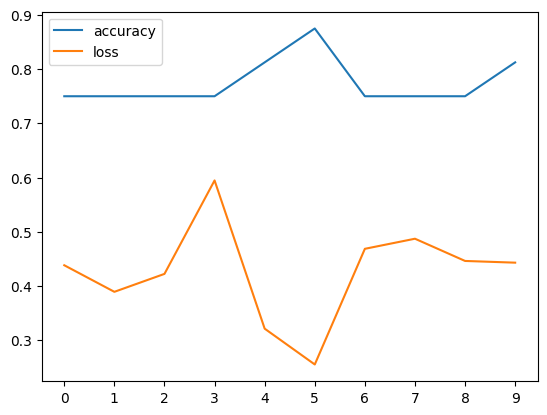

In [20]:
epoch_num = list(range(10))
fig, ax = plt.subplots(facecolor="w")
ax.plot(epoch_num, accuracy_list, label="accuracy")
ax.plot(epoch_num, loss_list, label="loss")
plt.xticks(epoch_num)
ax.legend()
plt.show()